In [1]:
# 可変基底非負値テンソル分解
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

# 切断ポアソン分布を生成する関数
def rtpois(mu, a, b, n, flag=0):
    FA = scipy.stats.poisson.cdf(a, mu)
    FB = scipy.stats.poisson.cdf(b, mu)
    x = np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")
    if flag==1:
        x = torch.Tensor(x)
    return x

# 切断ポアソン分布を高速で生成する関数
def rtpois_lw(mu, a, b, N, flag=0):
    x = np.random.poisson(mu, N)
    index = np.where(x==0)[0]
    x[index] = rtpois(mu[index], a, b, index.shape[0], 0)
    if flag==1:
        x = torch.Tensor(x)
    return x

# ガンマ分布を生成する関数
def Gamma(w1, w2, flag=0):
    x = np.random.gamma(w1, w2)
    if flag==1:
        x = torch.Tensor(x)
    return x

# データの生成 

In [3]:
# データと日付idの設定
# データの設定
k = 10
k_vec = np.repeat(1.0, k)
mode = 3
m = 3
hh = 3000
location = 2000
week = 7
month = 31
year = 12
max_week = 5
month_days = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
year_days = np.sum(month_days)
Lambda = np.random.gamma(40.0, 1/0.2, hh) 
pt = np.random.poisson(Lambda, hh)
N = np.sum(pt)

# 日付データを定義
day_dt = np.tile(np.arange(week), int((year_days*m)/week) + 1)[:m*year_days]
week_dt = np.tile(np.array(list(itertools.chain(*[np.repeat(np.arange(max_week), week)[:month_days[j]] for j in range(year)]))), m)
month_dt = np.tile(np.repeat(np.arange(year), month_days), m)
year_dt = np.repeat(np.arange(m), year_days)
date_dt = [day_dt, week_dt, month_dt, year_dt]
date_n = np.array([week, max_week, year, m])
week_freq = np.array(pd.Series(week_dt).value_counts(), dtype="int")
month_freq = np.array(pd.Series(month_dt).value_counts(), dtype="int")

In [4]:
# IDとインデックスを作成
# IDの定義
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

# インデックスの定義
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
# locationの生成
# 多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_location = np.random.dirichlet(np.repeat(0.2, location), topic)
z = rmnom(theta_topic[d_id, ], N, topic, 0)

# トピックからlocationを生成
location_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    location_id[index] = rmnom(phi_location[z[index], ], pt[i], location, 0)
    
# インデックスの定義
location_list = [i for i in range(location)]
location_n = np.repeat(0, location)
for i in range(location):
    location_list[i] = np.array(np.where(location_id==i)[0], dtype="int")
    location_n[i] = location_list[i].shape[0]

In [6]:
# dateの生成
# パラメータを生成
phi_day = np.random.dirichlet(np.repeat(0.2, week), topic)
phi_week = week_freq * np.random.dirichlet(np.repeat(0.2, max_week), topic)
phi_week = phi_week / np.sum(phi_week, axis=1)[:, np.newaxis]
phi_month = month_freq * np.random.dirichlet(np.repeat(0.2, year), topic)
phi_month = phi_week / np.sum(phi_month, axis=1)[:, np.newaxis]
phi_year = np.random.dirichlet(np.repeat(2.5, m), topic)

# トピックからdateを生成
z = rmnom(theta_topic[d_id, ], N, topic, 0)
year_id = np.repeat(0, N)
month_id = np.repeat(0, N)
week_id = np.repeat(0, N)
day_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    year_id[index] = rmnom(phi_year[z[index], ], pt[i], m, 0)
    month_id[index] = rmnom(phi_month[z[index], ], pt[i], year, 0)
    week_id[index] = rmnom(phi_week[z[index], ], pt[i], max_week, 0)
    day_id[index] = rmnom(phi_day[z[index], ], pt[i], week, 0)
date_id = np.array([day_id, week_id, month_id, year_id]).T

# インデックスの定義
year_list = [i for i in range(m)]
year_n = np.repeat(0, m)
for i in range(m):
    year_list[i] = np.array(np.where(year_id==i)[0], dtype="int")
    year_n[i] = year_list[i].shape[0]
    
month_list = [i for i in range(year)]
month_n = np.repeat(0, year)
for i in range(year):
    month_list[i] = np.array(np.where(month_id==i)[0], dtype="int")
    month_n[i] = month_list[i].shape[0]
    
week_list = [i for i in range(max_week)]
week_n = np.repeat(0, max_week)
for i in range(max_week):
    week_list[i] = np.array(np.where(week_id==i)[0], dtype="int")
    week_n[i] = week_list[i].shape[0]
    
day_list = [i for i in range(week)]
day_n = np.repeat(0, week)
for i in range(week):
    day_list[i] = np.array(np.where(day_id==i)[0], dtype="int")
    day_n[i] = day_list[i].shape[0]
date_list = [day_list, week_list, month_list, year_list]

In [7]:
# パラメータの生成
# 事前分布の設定
gamma = np.array([3.0, 1.0, 0.25, 0.5])
alpha1 = 0.25; alpha2 = 0.2
beta1 = 2.0; beta2 = 1.5

# モデルパラメータの生成
omega = np.random.dirichlet(gamma, hh)
theta_u = np.random.gamma(alpha1, beta1, hh*k).reshape(hh, k)
theta_v = np.random.gamma(alpha1, beta1, location*k).reshape(location, k)
theta_d = [j for j in range(mode+1)]
for j in range(mode):
    theta_d[j] = np.random.gamma(alpha2, beta2, date_n[j]*k).reshape(date_n[j], k)
theta_d[mode] = np.repeat(1.0, k)
omegat = omega.copy()
thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_d = theta_d.copy()

In [8]:
# 応答変数を生成
# 結合パラメータを定義
joint_theta = [j for j in range(mode+1)]
for j in range(mode+1):
    if k < mode:
        joint_theta[j] = theta_v[location_id, ] * theta_d[j][date_id[:, j], ]
    else:
        joint_theta[j] = theta_v[location_id, ]
        
# モデルの期待値
Z = rmnom(omega[d_id, ], N, mode+1, 1)[1]
uv = np.zeros((N, mode+1))
for j in range(mode+1):
    uv[:, j] = np.dot(theta_u[d_id, ] * joint_theta[j], k_vec)
mu = np.sum(Z * uv, axis=1)

# 切断ポアソン分布から応答変数を生成
x = rtpois(mu, 0, np.inf, N, flag=0)
y = x * np.random.binomial(1, 1 - np.exp(-mu), N)

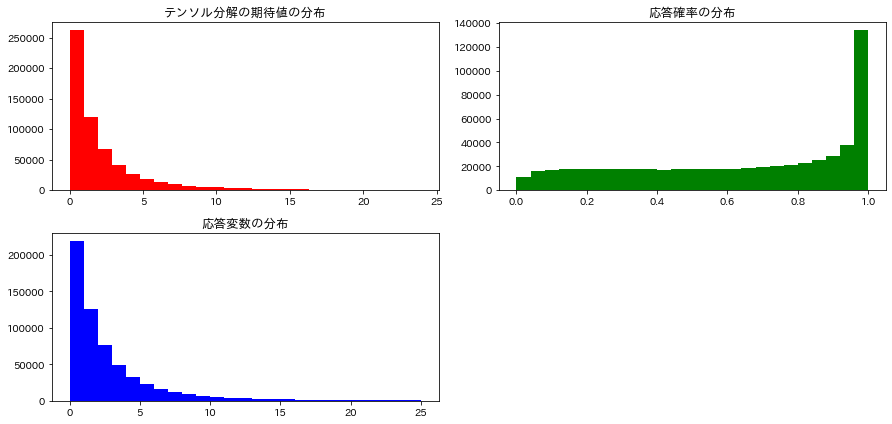

In [9]:
#生成したデータを可視化
Prob = 1 - np.exp(-mu)
dt = [mu, Prob, y]
fig_range = np.append(np.repeat(0.0, len(dt)), 
                      np.array([np.percentile(uv, 99.5), 1.0, np.percentile(y, 99.5)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["テンソル分解の期待値の分布", "応答確率の分布", "応答変数の分布"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

# テストデータの生成

In [10]:
# データの定義
pt0 = np.random.poisson(Lambda, hh)
N0 = np.sum(pt0)

# IDとインデックスを作成
# IDの定義
d_id0 = np.repeat(np.arange(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))

# インデックスの定義
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")

In [11]:
# locationの生成
# 多項分布からトピックを生成
topic = 30
z = rmnom(theta_topic[d_id0, ], N0, topic, 0)

# トピックからlocationを生成
location_id0 = np.repeat(0, N0)
for i in range(hh):
    index = d_list0[i]
    location_id0[index] = rmnom(phi_location[z[index], ], pt0[i], location, 0)
    
# インデックスの定義
location_list0 = [i for i in range(location)]
location_n0 = np.repeat(0, location)
for i in range(location):
    location_list0[i] = np.array(np.where(location_id0==i)[0], dtype="int")
    location_n0[i] = location_list0[i].shape[0]

In [12]:
# dateの生成
# トピックからdateを生成
z = rmnom(theta_topic[d_id0, ], N0, topic, 0)
year_id0 = np.repeat(0, N0)
month_id0 = np.repeat(0, N0)
week_id0 = np.repeat(0, N0)
day_id0 = np.repeat(0, N0)
for i in range(hh):
    index = d_list0[i]
    year_id0[index] = rmnom(phi_year[z[index], ], pt0[i], m, 0)
    month_id0[index] = rmnom(phi_month[z[index], ], pt0[i], year, 0)
    week_id0[index] = rmnom(phi_week[z[index], ], pt0[i], max_week, 0)
    day_id0[index] = rmnom(phi_day[z[index], ], pt0[i], week, 0)
date_id0 = np.array([day_id0, week_id0, month_id0, year_id0]).T

In [13]:
# 応答変数を生成
# 結合パラメータを定義
joint_theta = [j for j in range(mode+1)]
for j in range(mode+1):
    if k < mode:
        joint_theta[j] = theta_v[location_id0, ] * theta_d[j][date_id0[:, j], ]
    else:
        joint_theta[j] = theta_v[location_id0, ]
        
# モデルの期待値
Z0 = rmnom(omega[d_id0, ], N0, mode+1, 1)[1]
uv = np.zeros((N0, mode+1))
for j in range(mode+1):
    uv[:, j] = np.dot(theta_u[d_id0, ] * joint_theta[j], k_vec)
mu = np.sum(Z0 * uv, axis=1)

# 切断ポアソン分布から応答変数を生成
y0 = np.random.poisson(mu, N0)

# 可変基底非負値テンソル分解のパラメータを推定

In [14]:
# アルゴリズムの設定
R = 2000
keep = 2
burnin = 500
skeep = int(burnin/keep)
iters = 0
disp = 10

In [15]:
# 事前分布の設定
gamma = np.repeat(0.1, mode+1)
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.1
alpha3 = 0.1; beta3 = 1.0

In [16]:
# パラメータの真値
# モデルパラメータの真値
omega = omegat.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_d = thetat_d.copy()

# トピックの真値
Zi = Z.copy()
z_vec = np.dot(Zi, np.arange(mode+1))

In [17]:
# パラメータ初期値
# モデルパラメータの初期値
omega = np.random.dirichlet(10*gamma, hh)
theta_u = np.random.gamma(0.5, 1/1.0, hh*k).reshape(hh, k)
theta_v = np.random.gamma(0.5, 1/1.0, location*k).reshape(location, k)
theta_d = [j for j in range(mode+1)]
for j in range(mode):
    theta_d[j] = np.random.gamma(0.5, 1/1.0, date_n[j]*k).reshape(date_n[j], k)
theta_d[mode] = np.repeat(1.0, k)

# トピックの初期値
res = rmnom(omega[d_id, ], N, mode+1, 1)
z_vec = np.array(res[0], dtype="int8")
Zi = np.array(res[1], dtype="int8")

In [18]:
# パラメータの格納用配列
# モデルパラメータの格納用配列
RS = np.arange(skeep, int(R/keep))
rs = RS.shape[0]
OMEGA = np.zeros((hh, mode+1, rs))
THETA_U = np.zeros((hh, k, rs))
THETA_V = np.zeros((location, k, rs))
THETA_D1 = np.zeros((date_n[0], k, rs))
THETA_D2 = np.zeros((date_n[1], k, rs))
THETA_D3 = np.zeros((date_n[2], k, rs))

# 潜在変数の格納用配列
S = np.repeat(0.0, N)
SEG = np.zeros((N, mode+1), dtype="int")

In [19]:
# 対数尤度の基準値
# テストデータの1パラメータモデルの対数尤度
LLst0 = np.sum(scipy.stats.poisson.logpmf(y0, np.mean(y0)))
print(LLst0)

# 学習データの真値での対数尤度
joint_theta = [j for j in range(mode+1)]
uv = np.zeros((N, mode+1))
for j in range(mode+1):
    if k < mode:
        joint_theta[j] = thetat_v[location_id, ] * thetat_d[j][date_id[:, j], ]
    else:
        joint_theta[j] = thetat_v[location_id, ]
    uv[:, j] = np.dot(thetat_u[d_id, ] * joint_theta[j], k_vec)
mu = np.sum(Z * uv, axis=1)
y = x * np.random.binomial(1, 1 - np.exp(-mu), N)
LLbest = np.sum(scipy.stats.poisson.logpmf(y, mu))
print(LLbest)

# 学習データの1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.poisson.logpmf(y, np.mean(y)))
print(LLst)

# テストデータの真値での対数尤度
joint_theta = [j for j in range(mode+1)]
uv = np.zeros((N0, mode+1))
for j in range(mode+1):
    if k < mode:
        joint_theta[j] = thetat_v[location_id0, ] * thetat_d[j][date_id0[:, j], ]
    else:
        joint_theta[j] = thetat_v[location_id0, ]
    uv[:, j] = np.dot(thetat_u[d_id0, ] * joint_theta[j], k_vec)
mu = np.sum(Z0 * uv, axis=1)
LLbest0 = np.sum(scipy.stats.poisson.logpmf(y0, mu))
print(LLbest0)

-1884337.838214954
-842159.9126832475
-1888945.0919913019
-843803.2962967552


In [20]:
# ギブスサンプリングでパラメータをサンプリング
for rp in range(R):
    
    # 潜在変数sをサンプリング
    # 潜在変数sの割当確率
    joint_theta = [j for j in range(mode+1)]
    uv_deploy = [j for j in range(mode+1)]
    uv = np.zeros((N, mode+1))
    for j in range(mode+1):
        if k < mode:
            joint_theta[j] = theta_v[location_id, ] * theta_d[j][date_id[:, j], ]
        else:
            joint_theta[j] = theta_v[location_id, ]
        uv_deploy[j] = theta_u[d_id, ] * joint_theta[j]
        uv[:, j] = np.dot(uv_deploy[j], k_vec)
    mu = np.sum(Z * uv, axis=1)
    Prob1 = 1 - np.exp(-mu)

    # 潜在変数sから新しい変数を作成
    s = np.random.binomial(1, Prob1, N)
    y = s * x

    # トピックをサンプリング
    # トピックの割当確率
    Posterior = omega[d_id, ] * scipy.stats.poisson.pmf(y[:, np.newaxis] , uv)
    Prob2 = Posterior / np.sum(Posterior, axis=1)[:, np.newaxis]

    # 多項分布からトピックをサンプリング
    res = rmnom(Prob2, N, mode+1, 1)
    z_vec = np.array(res[0], dtype="int8")
    Zi = np.array(res[1], dtype="int8")

    # 基底分布をサンプリング
    for i in range(hh):
        index = d_list[i]
        wsum = np.sum(Zi[index, ], axis=0) + gamma
        omega[i, ] = np.random.dirichlet(wsum, 1).reshape(-1)


    # ユーザーパラメータをサンプリング
    # 補助変数deltaを更新
    theta_location = theta_v[location_id, ]
    theta_date = np.zeros((N, k)); theta_date[Zi[:, mode]==1, ] = 1.0
    lambda_deploy = np.zeros((N, k))
    for j in range(mode+1):
        z = Zi[:, j][:, np.newaxis]
        lambda_deploy += z * uv_deploy[j]  
        if j < mode:
            theta_date += z * theta_d[j][date_id[:, j], ]
    delta = lambda_deploy / np.sum(lambda_deploy, axis=1)[:, np.newaxis]

    # ガンマ分布の事後分布のパラメータ
    delta_y = delta * y[:, np.newaxis]
    W1 = np.zeros((hh, k)); W2 = np.zeros((hh, k))
    for i in range(hh):
        index = d_list[i]
        W1[i, ] = np.sum(delta_y[index, ], axis=0) + alpha1
        W2[i, ] = np.sum(theta_location[index, ], axis=0) + beta1

    # ガンマ分布からパラメータをサンプリング
    theta_u = np.random.gamma(W1, 1/W2)
    theta_user = theta_u[d_id, ]


    # locationパラメータをサンプリング
    # 補助変数deltaを更新
    lambda_deploy = theta_user * theta_location * theta_date
    delta = lambda_deploy / np.sum(lambda_deploy, axis=1)[:, np.newaxis]

    # ガンマ分布の事後分布のパラメータ
    delta_y = delta * y[:, np.newaxis]
    H1 = np.zeros((location, k)); H2 = np.zeros((location, k))
    for i in range(location):
        index = location_list[i]
        H1[i, ] = np.sum(delta_y[index, ], axis=0) + alpha2
        H2[i, ] = np.sum(theta_user[index, ] * theta_date[index, ], axis=0) + beta2

    # ガンマ分布からパラメータをサンプリング
    theta_v = np.random.gamma(H1, 1/H2)
    theta_location = theta_v[location_id, ]


    # dateパラメータをサンプリング
    # 補助変数deltaをサンプリング
    lambda_deploy = theta_user * theta_location * theta_date
    delta = lambda_deploy / np.sum(lambda_deploy, axis=1)[:, np.newaxis]

    # ガンマ分布の事後分布のパラメータ
    delta_y = delta * y[:, np.newaxis]
    for i in range(mode):
        D1 = np.zeros((date_n[i], k)); D2 = np.zeros((date_n[i], k))
        for j in range(date_n[i]):
            index = date_list[i][j]
            D1[j, ] = np.sum(delta_y[index, ], axis=0) + alpha3
            D2[j, ] = np.sum(theta_user[index, ] * theta_location[index, ], axis=0) + beta3

        # ガンマ分布からパラメータをサンプリング
        theta_d[i] = np.random.gamma(D1, 1/D2)


    # サンプリング結果の格納と表示
    # サンプリング結果の格納
    if (rp%keep==0) & (rp >= burnin):
        mkeep = int(rp/keep) - skeep
        OMEGA[:, :, mkeep] = omega
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_D1[:, :, mkeep] = theta_d[0]
        THETA_D2[:, :, mkeep] = theta_d[1]
        THETA_D3[:, :, mkeep] = theta_d[2]

        # 潜在変数を格納
        if rp >= burnin:
            S += s
            SEG += Zi

    # 対数尤度の更新と結果の表示
    if rp%disp==0:
        # 学習データの対数尤度
        joint_theta = [j for j in range(mode+1)]
        uv = np.zeros((N, mode+1))
        for j in range(mode+1):
            if k < mode:
                joint_theta[j] = theta_v[location_id, ] * theta_d[j][date_id[:, j], ]
            else:
                joint_theta[j] = theta_v[location_id, ]
            uv[:, j] = np.dot(theta_u[d_id, ] * joint_theta[j], k_vec)
        mu = np.sum(Zi * uv, axis=1)
        y = x * np.random.binomial(1, 1 - np.exp(-mu), N)
        LL = np.sum(scipy.stats.poisson.logpmf(y, mu))

        # テストデータの対数尤度
        joint_theta0 = [j for j in range(mode+1)]
        uv_deploy0 = [j for j in range(mode+1)]
        uv0 = np.zeros((N0, mode+1))
        for j in range(mode+1):
            if k < mode:
                joint_theta0[j] = theta_v[location_id0, ] * theta_d[j][date_id0[:, j], ]
            else:
                joint_theta0[j] = theta_v[location_id0, ]
            uv_deploy0[j] = theta_u[d_id0, ] * joint_theta0[j]
            uv0[:, j] = np.dot(uv_deploy0[j], k_vec)
        Posterior0 = omega[d_id0, ] * scipy.stats.poisson.pmf(y0[:, np.newaxis] , uv0)
        Prob0 = Posterior0 / np.sum(Posterior0, axis=1)[:, np.newaxis]
        Zi0 = rmnom(Prob0, N0, mode+1, 1)[1]
        mu0 = np.sum(Zi0 * uv0, axis=1)
        LL0 = np.sum(scipy.stats.poisson.logpmf(y0, mu0))

        # サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLbest, LLst], 1))
        print(np.round([LL0, LLbest0, LLst0], 1))

0
[-1540095.8  -842159.9 -1888945.1]
[-1758399.3  -843803.3 -1884337.8]
10
[-1198740.4  -842159.9 -1888945.1]
[-1368417.8  -843803.3 -1884337.8]
20
[-1122318.6  -842159.9 -1888945.1]
[-1310204.1  -843803.3 -1884337.8]
30
[-1041826.5  -842159.9 -1888945.1]
[-1205075.9  -843803.3 -1884337.8]
40
[ -966596.5  -842159.9 -1888945.1]
[-1098181.1  -843803.3 -1884337.8]
50
[ -912614.9  -842159.9 -1888945.1]
[-1024066.   -843803.3 -1884337.8]
60
[ -884143.1  -842159.9 -1888945.1]
[ -985984.4  -843803.3 -1884337.8]
70
[ -871673.1  -842159.9 -1888945.1]
[ -967932.8  -843803.3 -1884337.8]
80
[ -863246.1  -842159.9 -1888945.1]
[ -958142.4  -843803.3 -1884337.8]
90
[ -855275.   -842159.9 -1888945.1]
[ -948471.8  -843803.3 -1884337.8]
100
[ -842669.7  -842159.9 -1888945.1]
[ -933569.7  -843803.3 -1884337.8]
110
[ -835284.6  -842159.9 -1888945.1]
[ -922719.7  -843803.3 -1884337.8]
120
[ -830583.7  -842159.9 -1888945.1]
[ -917381.6  -843803.3 -1884337.8]
130
[ -828488.1  -842159.9 -1888945.1]
[ -915476.

1110
[ -824769.6  -842159.9 -1888945.1]
[ -909143.1  -843803.3 -1884337.8]
1120
[ -824915.   -842159.9 -1888945.1]
[ -908070.1  -843803.3 -1884337.8]
1130
[ -825426.7  -842159.9 -1888945.1]
[ -908041.8  -843803.3 -1884337.8]
1140
[ -825614.5  -842159.9 -1888945.1]
[ -909122.1  -843803.3 -1884337.8]
1150
[ -825069.7  -842159.9 -1888945.1]
[ -908959.3  -843803.3 -1884337.8]
1160
[ -825315.8  -842159.9 -1888945.1]
[ -909529.6  -843803.3 -1884337.8]
1170
[ -826103.8  -842159.9 -1888945.1]
[ -907904.9  -843803.3 -1884337.8]
1180
[ -825401.5  -842159.9 -1888945.1]
[ -907544.   -843803.3 -1884337.8]
1190
[ -825834.6  -842159.9 -1888945.1]
[ -907321.9  -843803.3 -1884337.8]
1200
[ -825589.1  -842159.9 -1888945.1]
[ -906882.2  -843803.3 -1884337.8]
1210
[ -825946.7  -842159.9 -1888945.1]
[ -906968.2  -843803.3 -1884337.8]
1220
[ -826231.   -842159.9 -1888945.1]
[ -906843.6  -843803.3 -1884337.8]
1230
[ -825559.1  -842159.9 -1888945.1]
[ -907772.4  -843803.3 -1884337.8]
1240
[ -826302.6  -842159

KeyboardInterrupt: 